# Animated GIF for plays using ggplot

Because not all of us are matplotlib lovers, I decided to provide some baseline code for all my R users out there. 

This notebook aims to provide functions for generating an **animated GIF** of a play as well as provide a function for plotting a specific frame of a play.

**Note:** Huge shoutout to [Adam Sonty](https://asonty.netlify.app/) because all of the codes in this notebook are heavily based on his previous work. 

![](https://ggplot2.tidyverse.org/logo.png)

### Install the necessary packages and load some data

In [1]:
#install.packages('tidyverse')
#install.packages('gganimate')
#install.packages('patchwork')
#install.packages('magick')
#install.packages('gifski')

suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(gganimate))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(magick))
suppressPackageStartupMessages(library(gifski))


players <- read_csv("../input/nfl-big-data-bowl-2023/players.csv", show_col_types = FALSE)
games <- read_csv("../input/nfl-big-data-bowl-2023/games.csv", show_col_types = FALSE)
plays <- read_csv("../input/nfl-big-data-bowl-2023/plays.csv", show_col_types = FALSE)
df <- read_csv("../input/nfl-big-data-bowl-2023/week1.csv", show_col_types = FALSE)



## Data utils functions
Before generating our plots, we need to define some functions for:
* Exctracting plays from our data.
* Getting team colors for our plots.

In [2]:
fetch_team_colors <- function() {
  team_colors_ <- suppressMessages(readr::read_tsv("https://raw.githubusercontent.com/asonty/ngs_highlights/master/utils/data/nfl_team_colors.tsv"))
  # add football color
  team_colors_ = rbind(team_colors_, c("football","#935e38","black","#935e38"))
  return(team_colors_)
}
team_colors_ <- fetch_team_colors()

fetch_play <- function(df,playId_,gameId_)
{
  # ' Function that returns a play dataframe with its correspondent information
  play <- df %>% 
    filter(gameId == gameId_ & playId == playId_) %>% 
    left_join(plays, by = c("playId" = "playId", "gameId" = "gameId")) %>% 
    left_join(team_colors_, by = c("team"="teams"))
  return(play)
}

## Plotting functions
***

These functions are based on **asonty's** work from a couple of years ago. Be sure to check out [his work](https://github.com/asonty/ngs_highlights)! 


#### Plotting the field

`plot_field` function returns a ggplot object that plots a football field. You can change the field and line colors in the function arguments.

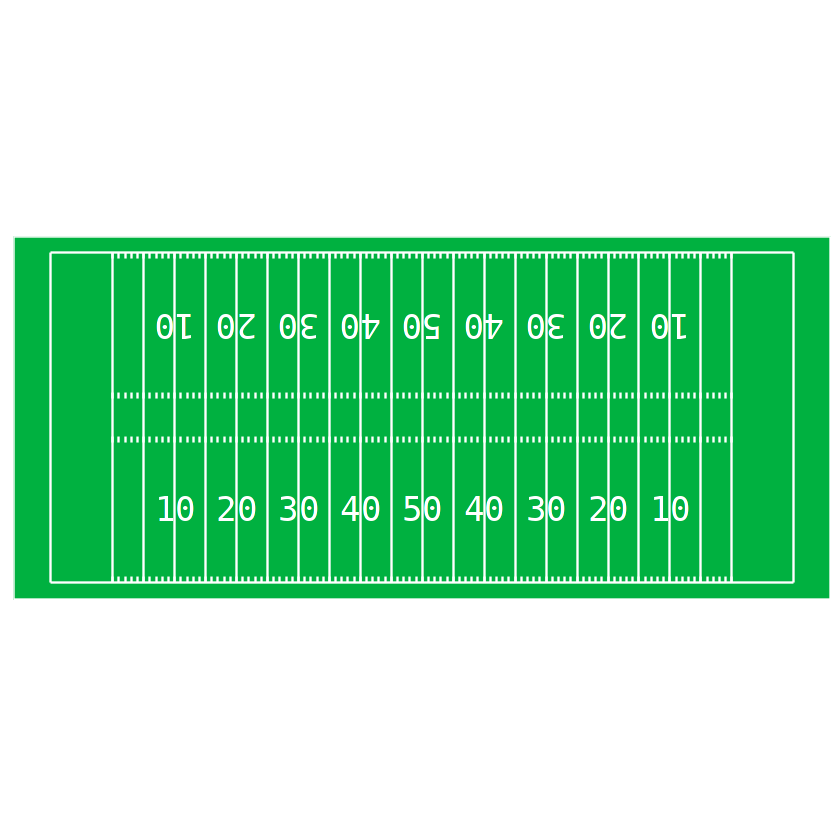

In [3]:
plot_field <- function(field_color="#00b140", line_color = "#ffffff") {
  field_height <- 160/3
  field_width <- 120
  
  field <- ggplot() +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 13, hjust = 0.5),
      plot.subtitle = element_text(hjust = 1),
      legend.position = "bottom",
      # legend.title = element_text(color = "#212529", size = 12, vjust = 1),
      legend.title.align = 1,
      # legend.text = element_text(color = "#343a40", size = 10),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      axis.title = element_blank(),
      axis.ticks = element_blank(),
      axis.text = element_blank(),
      axis.line = element_blank(),
      # panel.background = element_blank(),
      panel.background = element_rect(fill = field_color, color = "white"),
      panel.border = element_blank(),
      aspect.ratio = field_height/field_width
    ) +
    # major lines
    annotate(
      "segment",
      x = c(0, 0, 0,field_width, seq(10, 110, by=5)),
      xend = c(field_width,field_width, 0, field_width, seq(10, 110, by=5)),
      y = c(0, field_height, 0, 0, rep(0, 21)),
      yend = c(0, field_height, field_height, field_height, rep(field_height, 21)),
      colour = line_color
    ) +
    # hashmarks
    annotate(
      "segment",
      x = rep(seq(10, 110, by=1), 4),
      xend = rep(seq(10, 110, by=1), 4),
      y = c(rep(0, 101), rep(field_height-1, 101), rep(160/6 + 18.5/6, 101), rep(160/6 - 18.5/6, 101)),
      yend = c(rep(1, 101), rep(field_height, 101), rep(160/6 + 18.5/6 + 1, 101), rep(160/6 - 18.5/6 - 1, 101)),
      colour = line_color
    ) +
    # yard numbers
    annotate(
      "text",
      x = seq(20, 100, by = 10),
      y = rep(12, 9),
      label = c(seq(10, 50, by = 10), rev(seq(10, 40, by = 10))),
      size = 7,
      family = "mono",
      colour = line_color, # "#495057",
    ) +
    # yard numbers upside down
    annotate(
      "text",
      x = seq(20, 100, by = 10),
      y = rep(field_height-12, 9),
      label = c(seq(10, 50, by = 10), rev(seq(10, 40, by = 10))),
      angle = 180,
      size = 7,
      family = "mono",
      colour = line_color, 
    )
  
  return(field)
}

plot_field()

#### Plotting one frame of a play
`plot_frame` takes a play dataframe and a frame number as inputs and returns a scatterplot of the selected frame.

In [4]:
plot_frame <- function(onePlay_, frame_, plot_vel_ = F)
{
  #  Take one frame from one play, plot a scatter plot image.
  
  # Check for data
  if(is.null(onePlay_)) {
    print("error: need to provide play data")
    return()
  }
  if(is.null(frame_)) {
    print("error: need to provide frame of play to visualize")
    return()
  }
  # * get play metadata ----
  play_desc <- onePlay_$playDescription %>% .[1]
  play_dir <- onePlay_$playDirection %>% .[1]
  yards_togo <- onePlay_$yardsToGo %>% .[1]
  los <- onePlay_$absoluteYardlineNumber %>% .[1]
  togo_line <- if(play_dir=="left") los-yards_togo else los+yards_togo
  
  fr <- onePlay_ %>% 
    filter(frameId == frame_)
  
  colores        <- unique(fr$color1)
  names(colores) <- colores
    
  #  velocity angle in radians
  fr$dir_rad <- fr$dir * pi / 180
  
  #  velocity components
  fr$v_x <- sin(fr$dir_rad) * fr$s
  fr$v_y <- cos(fr$dir_rad) * fr$s
    
if(plot_vel_ == T)
{
    # one frame scatterplot
  one_frame <- plot_field() +
    # line of scrimmage
    annotate(
      "segment",
      x = los, xend = los, y = 0, yend = 160/3,
      colour = "#0d41e1"
    ) +
    # 1st down marker
    annotate(
      "segment",
      x = togo_line, xend = togo_line, y = 0, yend = 160/3,
      colour = "#f9c80e"
    )+
    geom_point(
      data = fr,
      mapping = aes(x = x, y = y, color = color1 )
      ) +
    geom_segment(
        data = fr,
        mapping = aes(x = x, y = y, xend = x + v_x, yend = y + v_y, color =color1 ),
        size = 1, arrow = arrow(length = unit(0.1, "cm"))
  ) + 
    scale_colour_manual(values = colores) +
    labs(
      title = play_desc,
      caption = "Data: Big Data Bowl 2023"
    ) +
    theme(legend.position="none")
}
else
{
    # one frame scatterplot
  one_frame <- plot_field() +
    # line of scrimmage
    annotate(
      "segment",
      x = los, xend = los, y = 0, yend = 160/3,
      colour = "#0d41e1"
    ) +
    # 1st down marker
    annotate(
      "segment",
      x = togo_line, xend = togo_line, y = 0, yend = 160/3,
      colour = "#f9c80e"
    )+
    geom_point(
      data = fr,
      mapping = aes(x = x, y = y, color = color1 )
      ) +
    scale_colour_manual(values = colores) +
    labs(
      title = play_desc,
      caption = "Data: Big Data Bowl 2023"
    ) +
    theme(legend.position="none")
}
  
  
  
    
  
  return(one_frame)
  
}


For our example we will use one of Dak Prescott's deep passes to Amari Cooper (`playId = 137`) in the Tampa Bay vs Dallas game (`gameId = 2021090900`)

In [5]:
# ---- establish game and play to plot ----
playId_ = 137
gameId_ = 2021090900
#-------------------------------------------

# exctract play df ----
play <- fetch_play(df, playId_, gameId_)
head(play)
colnames(play)

gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,⋯,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,color1,color1_family,color2
<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
2021090900,137,35441,1,2021-09-10 00:28:09,93,TB,left,106.92,20.83,⋯,"1 RB, 2 TE, 2 WR",6,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,#D50A0A,red,#34302B
2021090900,137,35441,2,2021-09-10 00:28:10,93,TB,left,106.90,20.83,⋯,"1 RB, 2 TE, 2 WR",6,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,#D50A0A,red,#34302B
2021090900,137,35441,3,2021-09-10 00:28:10,93,TB,left,106.96,20.99,⋯,"1 RB, 2 TE, 2 WR",6,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,#D50A0A,red,#34302B
2021090900,137,35441,4,2021-09-10 00:28:10,93,TB,left,107.02,21.09,⋯,"1 RB, 2 TE, 2 WR",6,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,#D50A0A,red,#34302B
2021090900,137,35441,5,2021-09-10 00:28:10,93,TB,left,107.08,21.17,⋯,"1 RB, 2 TE, 2 WR",6,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,#D50A0A,red,#34302B
2021090900,137,35441,6,2021-09-10 00:28:10,93,TB,left,107.18,21.25,⋯,"1 RB, 2 TE, 2 WR",6,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,#D50A0A,red,#34302B


[1] "gameId"                 "playId"                 "nflId"                 
 [4] "frameId"                "time"                   "jerseyNumber"          
 [7] "team"                   "playDirection"          "x"                     
[10] "y"                      "s"                      "a"                     
[13] "dis"                    "o"                      "dir"                   
[16] "event"                  "playDescription"        "quarter"               
[19] "down"                   "yardsToGo"              "possessionTeam"        
[22] "defensiveTeam"          "yardlineSide"           "yardlineNumber"        
[25] "gameClock"              "preSnapHomeScore"       "preSnapVisitorScore"   
[28] "passResult"             "penaltyYards"           "prePenaltyPlayResult"  
[31] "playResult"             "foulName1"              "foulNFLId1"            
[34] "foulName2"              "foulNFLId2"             "foulName3"             
[37] "foulNFLId3"             "absoluteYardlineNumber" "offenseFormation"      
[40] "personnelO"             "defendersInBox"         "personnelD"            
[43] "dropBackType"           "pff_playAction"         "pff_passCoverage"      
[46] "pff_passCoverageType"   "color1"                 "color1_family"         
[49] "color2"

In [6]:
print(play$playDescription %>% .[1])

[1] "(13:18) (Shotgun) D.Prescott pass deep left to A.Cooper pushed ob at DAL 30 for 28 yards (A.Winfield)."


Plot one single frame:


Warning message:
“Removed 1 rows containing missing values (geom_segment).”


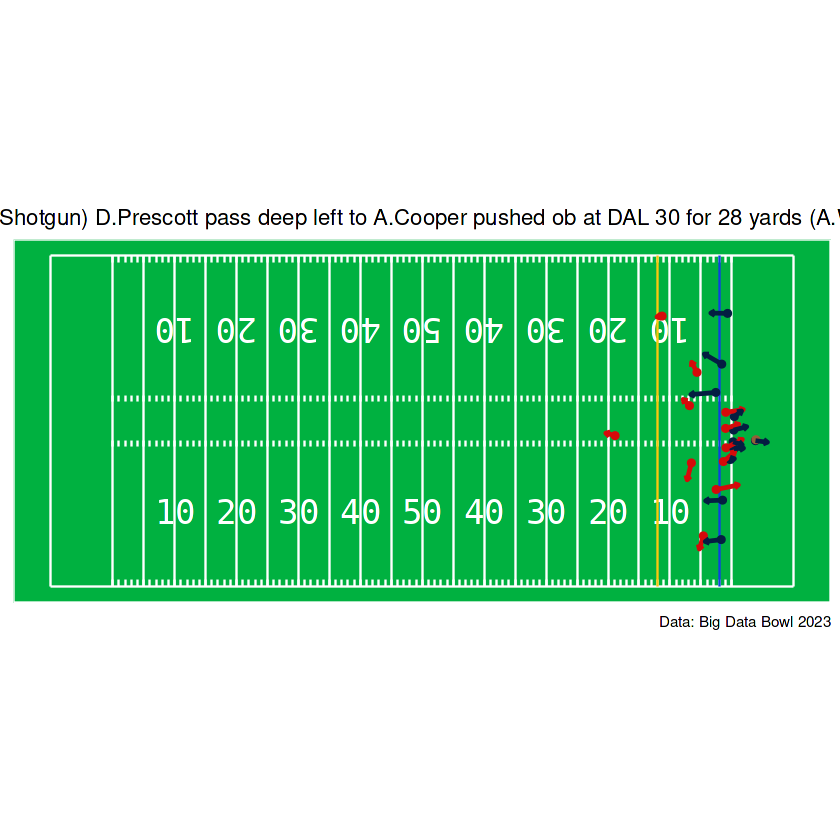

In [7]:
# plot a specific frame ----
plot_frame(play,15,TRUE)

#### Animating a play
First, we need to define the plotting function:

In [8]:
play_animation <- function(onePlay_ , plot_vel_ = F)
{
  
  # Check for data
  if(is.null(onePlay_)) {
    print("error: need to provide play data")
    return()
  }
  # * get play metadata ----
  play_desc <- onePlay_$playDescription %>% .[1]
  play_dir <- onePlay_$playDirection %>% .[1]
  yards_togo <- onePlay_$yardsToGo %>% .[1]
  los <- onePlay_$absoluteYardlineNumber %>% .[1]
  togo_line <- if(play_dir=="left") los-yards_togo else los+yards_togo
  
  colores        <- unique(onePlay_$color1)
  names(colores) <- colores
    
      #  velocity angle in radians
  onePlay_$dir_rad <- onePlay_$dir * pi / 180
  
  #  velocity components
  onePlay_$v_x <- sin(onePlay_$dir_rad) * onePlay_$s
  onePlay_$v_y <- cos(onePlay_$dir_rad) * onePlay_$s
    
if (plot_vel_ == T)
{
    anim <- plot_field() +
    # line of scrimmage
    annotate(
      "segment",
      x = los, xend = los, y = 0, yend = 160/3,
      colour = "#0d41e1"
    ) +
    # 1st down marker
    annotate(
      "segment",
      x = togo_line, xend = togo_line, y = 0, yend = 160/3,
      colour = "#f9c80e"
    )+
    geom_point(
      data = onePlay_,
      mapping = aes(x = x, y = y, color = color1 ),
      size = 4
    ) +
    geom_segment(
        data = onePlay_,
        mapping = aes(x = x, y = y, xend = x + v_x, yend = y + v_y, color =color1),
        size = 1, arrow = arrow(length = unit(0.01, "npc"))
      ) + 
    scale_colour_manual(values = colores) +
    labs(
      title = play_desc,
      caption = "Data: Big Data Bowl 2023"
    ) +
    theme(legend.position="none")+
    # animation stuff
    transition_time(frameId) +
    ease_aes('linear') +
    NULL  
}
    
    else 
    {
    anim <- plot_field() +
    # line of scrimmage
    annotate(
      "segment",
      x = los, xend = los, y = 0, yend = 160/3,
      colour = "#0d41e1"
    ) +
    # 1st down marker
    annotate(
      "segment",
      x = togo_line, xend = togo_line, y = 0, yend = 160/3,
      colour = "#f9c80e"
    )+
    geom_point(
      data = onePlay_,
      mapping = aes(x = x, y = y, color = color1 ),
      size = 4
    ) +
    scale_colour_manual(values = colores) +
    labs(
      title = play_desc,
      caption = "Data: Big Data Bowl 2023"
    ) +
    theme(legend.position="none")+
    # animation stuff
    transition_time(frameId) +
    ease_aes('linear') +
    NULL
    }
  

  
  return(anim)
}


Then, we pass the output of `play_animation` to the `animate` function and save our output.

In [9]:
# *ensure length of play matches number of frames
play_length <- length(unique(play$frameId))

# customize duration of gif
duration_ = 7

# Animate our play! :D
p_anim <- animate(
    play_animation(play, plot_vel_ = T),
    duration = 7,
    fps = 10, 
    nframe = play_length,
    width = 850,
    height = 500,
    end_pause = 10,
    renderer = gifski_renderer()
)
anim_save("play.gif", p_anim)

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning mess

Display our animated play! :D

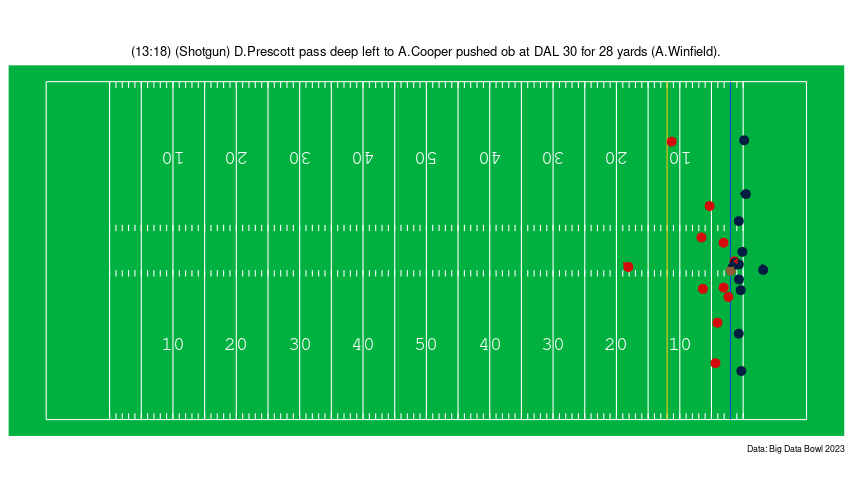

In [10]:
IRdisplay::display_png(file="play.gif")

Although the output is very simple, it can provide a starting point for those who want to add more features in the future :) 

I plan to keep updating this notebook with new features so be sure to check in regularly for new aditions. 

## Now let's plot the velocity and direction of defensive players
